In [150]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import itertools

In [151]:
class LSTM():
    
    def __init__(self):
        self.model     = tf.keras.models.Sequential([
                             tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
                             tf.keras.layers.Dense(1)
                        ])
        self.optimizer = 'Adam'
        self.loss      = 'mae'
        
    def train(self,training_data,EOPCHS, EVALUATION_INTERVAL, validation_data):
        self.model.fit(training_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation_data, validation_steps=50)
    def compile(self):
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
    
    def predict(self,data):
        return self.model.predict(data)


In [152]:
def DataLoader(fname):
    x = []
    y = []
    with open(fname, 'r') as csvfile:
            plots = csv.reader(csvfile, delimiter = ",")
            for row in plots:
                    x.append(float(row[0]))
                    y.append(float(row[1]))
    return x,y 

def normalise_data(data):
    data = tf.keras.utils.normalize(data)
    return data[0]

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data  = []
    labels = []
    
    start_index += history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indicies = range(i-history_size, i)
        reshaped_data = np.reshape(dataset[indicies], (history_size,1))
        data.append(reshaped_data)
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length,0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()



In [153]:
midprices_fname = '../BSE/midprice.csv'
transactions_fname = '../BSE/transactions.csv'

midprice_x, midprice_y = DataLoader(midprices_fname)
transaction_x, transaction_y = DataLoader(transactions_fname)

midprice_x, midprice_y = normalise_data(np.array(midprice_x)), normalise_data(np.array(midprice_y))

transaction_x, transaction_y = normalise_data(np.array(transaction_x)), normalise_data(np.array(transaction_y))
print(len(midprice_x))

7002


In [154]:
TRAIN_SPLIT = 5000
univariate_past_history = 40
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(midprice_y, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(midprice_y, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
    

In [160]:
BATCH_SIZE = 256
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))

val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
val_univariate


<RepeatDataset shapes: ((None, 40, 1), (None,)), types: (tf.float64, tf.float64)>

In [156]:
EVALUATION_INTERVAL = 300
EPOCHS = 10
midprice_model = LSTM()
midprice_model.compile()
midprice_model.train(train_univariate, EPOCHS, EVALUATION_INTERVAL, val_univariate )


Epoch 1/10
300/300 [==============================] - 6s 19ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 2/10
300/300 [==============================] - 5s 18ms/step - loss: 8.5101e-04 - val_loss: 0.0023
Epoch 3/10
300/300 [==============================] - 5s 17ms/step - loss: 7.9078e-04 - val_loss: 0.0019
Epoch 4/10
300/300 [==============================] - 5s 17ms/step - loss: 6.5583e-04 - val_loss: 0.0014
Epoch 5/10
300/300 [==============================] - 5s 17ms/step - loss: 5.1580e-04 - val_loss: 0.0015
Epoch 6/10
300/300 [==============================] - 5s 17ms/step - loss: 5.1136e-04 - val_loss: 0.0012
Epoch 7/10
300/300 [==============================] - 5s 17ms/step - loss: 4.9110e-04 - val_loss: 0.0014
Epoch 8/10
300/300 [==============================] - 5s 17ms/step - loss: 4.2417e-04 - val_loss: 7.7255e-04
Epoch 9/10
300/300 [==============================] - 5s 17ms/step - loss: 3.7757e-04 - val_loss: 4.2495e-04
Epoch 10/10
300/300 [==============================

<RepeatDataset shapes: ((None, 40, 1), (None,)), types: (tf.float64, tf.float64)>
[0.0126252]


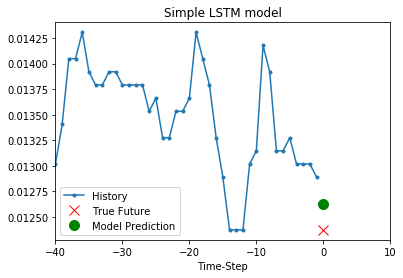

AttributeError: 'NoneType' object has no attribute 'show'

In [159]:
print(val_univariate)
for x, y in val_univariate.take(2):
        prediction = midprice_model.predict(x)[0]
        print (prediction)
        plot = show_plot([x[0].numpy(), y[0].numpy(),
                    prediction], 0, 'Simple LSTM model')
        plot.show()
    